### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

In [2]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [3]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [4]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [5]:
query = "Can I get a tablet?"

In [6]:
answer = retrieve_data(query, qdrant_client, k=10)

In [7]:
answer

{'retrieved_context_ids': ['B0BKTKFSQW',
  'B0B82NTNRR',
  'B0B927GGCY',
  'B0C33ZB3H6',
  'B0BQ7K7ZT8',
  'B0BGSHMC98',
  'B09V2RBL2B',
  'B0C4DLHNRD',
  'B0BT263ZT9',
  'B0C74FK8R4'],
 'retrieved_context': ['TISHLED Typewriter Keyboard Wireless Bluetooth 5.0 Retro Aesthetic Cute Kawaii Round Keycaps 106-Key with Num Pad Clicky Mechanical Feeling with Pad/Phone Holder for Windows/Mac OS/Android/iOS (Mint) [Powerful Bluetooth 5.0 Technology] - The wireless keyboard can connect up to 3 bluetooth devices. Easy to switch between devices by pressing Fn+1/2/3. Limitless method for typing and gaming within 33FT(10m) in clear sight without delays. *ONLY Supports Bluetooth Connection. *Bluetooth USB receiver and USB cable not included. [Retro Aesthetic Typewriter Style Keyboard] - The typewriter keyboard is a fusion of retro style and modern design. Cute white round keycaps and advanced wireless technology make typing more comfortable and enjoyable. [Membrane Keys (Not Mechanical Keys)] - Medi

### Multi-Intent Questions

In [8]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"

In [9]:
answer = retrieve_data(query, qdrant_client, k=10)

In [10]:
answer

{'retrieved_context_ids': ['B0C74FK8R4',
  'B0BRXCBH3R',
  'B09WK85391',
  'B0BGSHMC98',
  'B0C33ZB3H6',
  'B0BKTKFSQW',
  'B0BT263ZT9',
  'B0C7CG4CNS',
  'B0C4DLHNRD',
  'B0BWMJ53MD'],
 'retrieved_context': ['Wireless Mouse Bluetooth Pink Mouse Cute Hamster Shape Kawaii Portable Ergonomic Silent Lightweight Quiet Cordless Gaming Mice for PC Laptop Computer Mac iPad Pro MacBook Pro/Air Gift(No Receiver) 【Cute Mouse with Bluetooth Connection】This cute bluetooth mouse compatible with PCs, MacBook,iMac,Windows, Android, Linux, iPhone, iPad,Mac OS.Do not occupy any usb ports or usb c ports,easy to use.with novelty cool cute hamster shape design,this bluetooth mouse for laptop gives you a vibrant look to create your personal desk setup, add fun to the typing process. Kids will be more willing to learn online lessons with this cute wireless mouse.Perfect for work and entertainment in home or office 【Compact Design】with lightweight, portable design,this cute bluetooth mouse for ipad is perfec

In [13]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [11]:
def query_expand_node(query) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "queries": response.statements
   }

In [14]:
answer = query_expand_node(query)

In [15]:
answer

{'queries': ['tablet suitable for kids',
  'smartwatch for adults',
  'laptop for women']}

### LangGraph

#### Query Expansion (Sequential Execution)

In [16]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

#### Query Expansion / Rewriting Node

In [17]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

In [18]:
@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.
- Be as concise as possible, do not make up synonims for statements, one statement per piece of context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
   }

#### Retriever Node

In [19]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_data(query, k=5):

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


@traceable(
    name="retriever_node",
    run_type="retriever"
)
def retriever_node(state: State) -> dict:

    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve_data(query, k=5))

    return {
        "retrieved_context": retrieved_context
    }

#### Aggregator Node

In [20]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [21]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

In [22]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retriever_node")
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

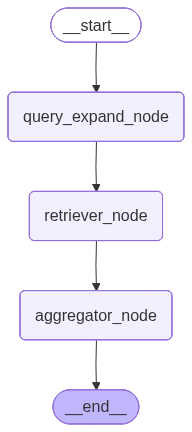

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query,
}

In [25]:
result = graph.invoke(initial_state)

In [26]:
result

{'expanded_query': ['tablet for kids',
  'watch for adults',
  'laptop for adults'],
 'retrieved_context': ['- ID: B0C74FK8R4, rating: 4.3, description: Wireless Mouse Bluetooth Pink Mouse Cute Hamster Shape Kawaii Portable Ergonomic Silent Lightweight Quiet Cordless Gaming Mice for PC Laptop Computer Mac iPad Pro MacBook Pro/Air Gift(No Receiver) 【Cute Mouse with Bluetooth Connection】This cute bluetooth mouse compatible with PCs, MacBook,iMac,Windows, Android, Linux, iPhone, iPad,Mac OS.Do not occupy any usb ports or usb c ports,easy to use.with novelty cool cute hamster shape design,this bluetooth mouse for laptop gives you a vibrant look to create your personal desk setup, add fun to the typing process. Kids will be more willing to learn online lessons with this cute wireless mouse.Perfect for work and entertainment in home or office 【Compact Design】with lightweight, portable design,this cute bluetooth mouse for ipad is perfect for travel or on-the-go use.Easy to put this wireless m

In [27]:
print(result["answer"])

Based on the available products, there is no tablet, watch, or laptop explicitly listed for sale. However, there are some related items that might interest you:

- For a kid, there are gaming accessories and card binders which are suitable for children, such as the LIUDU Card Binder 9-Pocket for game cards and Nintendo Switch Sports Accessories for kids.
- For a watch, there is a Fitness Tracker - Activity Tracker Watch with Heart Rate Blood Pressure Sleep Monitor, though it has a lower rating of 3.1.
- For a laptop, there are accessories like wireless mice compatible with laptops (e.g., the Wireless Mouse Bluetooth Pink Mouse Cute Hamster Shape) but no actual laptops are listed.

If you want, I can help you find specific accessories or gadgets for your family within these categories.


#### Query Expansion (Parallel Execution)

In [2]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion / Rewriting Node

In [3]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

In [4]:
@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
   }

In [5]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

#### Retriever Node

In [6]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context]
    }

#### Aggregator Node

In [7]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [8]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

#### Graph

In [9]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

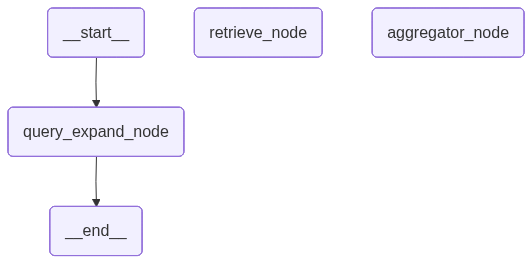

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query,
}

In [13]:
result = graph.invoke(initial_state)

In [14]:
result

{'expanded_query': ['tablet for kids', 'watch for adults', 'laptop for wife'],
 'retrieved_context': ['- ID: B0C74FK8R4, rating: 4.3, description: Wireless Mouse Bluetooth Pink Mouse Cute Hamster Shape Kawaii Portable Ergonomic Silent Lightweight Quiet Cordless Gaming Mice for PC Laptop Computer Mac iPad Pro MacBook Pro/Air Gift(No Receiver) 【Cute Mouse with Bluetooth Connection】This cute bluetooth mouse compatible with PCs, MacBook,iMac,Windows, Android, Linux, iPhone, iPad,Mac OS.Do not occupy any usb ports or usb c ports,easy to use.with novelty cool cute hamster shape design,this bluetooth mouse for laptop gives you a vibrant look to create your personal desk setup, add fun to the typing process. Kids will be more willing to learn online lessons with this cute wireless mouse.Perfect for work and entertainment in home or office 【Compact Design】with lightweight, portable design,this cute bluetooth mouse for ipad is perfect for travel or on-the-go use.Easy to put this wireless mouse f

In [15]:
print(result["answer"])

Based on the available products, there are no tablets or laptops specifically listed for sale. However, there is a fitness tracker watch available for you. Here are the details:

Fitness Tracker - Activity Tracker Watch
- Features: Heart Rate, Blood Pressure, Sleep Monitor
- Rating: 3.1

Unfortunately, there are no tablets or laptops in the current stock for your kid or wife.
